In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from skmap.misc import find_files, GoogleSheet, ttprint
import warnings
import multiprocess as mp
import time
from scipy.special import expit, logit
import warnings
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, HalvingGridSearchCV, KFold, GroupKFold, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor 
import joblib
import pickle
from sklearn.metrics import r2_score, mean_squared_error, make_scorer#, root_mean_squared_error
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
# from cubist import Cubist
from sklearn.base import BaseEstimator, TransformerMixin
from pathlib import Path
from trees_rf import TreesRandomForestRegressor
from model_fit import read_features, cfi_calc, parameter_fine_tuning, calc_ccc, separate_data, rscfi 
from model_fit import accuracy_plot, plot_top_features, pdp_hexbin, plot_histogram, calc_metrics, accuracy_strata_plot
import warnings
warnings.filterwarnings('ignore')
import os
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import json
from datetime import datetime

folder_path = '/mnt/ripley/global_soc/scikit-map/global-soil-mapping'
# prop_list = ['ocd', 'soc', 'bulk.density', 'ph.h2o', 'coarse']
prop_list = ['ocd', 'soc', 'bulk.density', 'ph.h2o']
transforms_dict = {
    'ocd': 'log1p',
    'soc': 'log1p',
    'bulk.density': None,
    'ph.h2o': None,
    'coarse': 'log1p'
}
version = '20250204'

min_convs_num = 60
max_convs_num = 120

# Separate Calibration (Cal), Train, and Test Data

Perform this separation **only once**, then save and read the separated data to ensure reproducibility.

#### Data ratio:
- **When data is limited**: Maintain the ratio between calibration, train, and test sets as `1:8:1`.
- **When data is abundant**: Allocate around **8,000 samples** for calibration and **6,000 samples** for testing.

#### How:
- **Strata with very few samples** (`count < 3`): Randomly assign samples to a set.
- **Strata with few samples** (`3 ≤ count < 10`): Distribute samples evenly across the sets.
- **Strata with sufficient samples** (`count ≥ 10`): Assign samples according to the specified ratio.


In [2]:
df = pd.read_parquet(f'{folder_path}/material/soil_pnts_organized_v{version}.pq')

for prop in prop_list:
    print(f'\n{prop}--------------------------------------------------------------')
    space = transforms_dict[prop]
    output_folder = folder_path+'/'+prop
    os.makedirs(output_folder, exist_ok=True)
       
    cal, train, test = separate_data(prop, space, output_folder, version, df, strata_col = ['hzn_dep_bin','clm_class'])


ocd--------------------------------------------------------------
6 small strata groups, with 23 data records
small strata groups: ['60-100,warm temperate winter dry cool summer', '30-60,warm temperate winter dry cool summer', '>100,warm temperate winter dry cool summer', '>100,snow summer dry hot summer', '0-30,warm temperate summer dry cool summer', '60-100,warm temperate summer dry cool summer']
size: calibration 8005, training 201926, test 6005
ratio: calibration 0.04, training 0.94, test 0.03
sum 215936, df 215936

soc--------------------------------------------------------------
5 small strata groups, with 17 data records
small strata groups: ['60-100,warm temperate winter dry cool summer', '30-60,warm temperate winter dry cool summer', '>100,warm temperate winter dry cool summer', '60-100,warm temperate summer dry cool summer', '30-60,warm temperate summer dry cool summer']
size: calibration 8005, training 394257, test 6003
ratio: calibration 0.02, training 0.97, test 0.01
sum 

# Model calibration

In [3]:
with open(f'{folder_path}/material/soil_cov_no.bimonthly.landsat_v{version}.json', "r") as file:
    covar_cols = json.load(file)
print('total cov number: ', len(covar_cols))

for prop in prop_list:
    print(f'\n{prop}--------------------------------------------------------------')
    space = transforms_dict[prop]
    output_folder = folder_path+'/'+prop
    os.makedirs(output_folder, exist_ok=True)
    
    if space=='log1p':
        # df.loc[:,f'{prop}_log1p'] = np.log1p(df[prop])
        tgt = f'{prop}_log1p'
    # elif space=='boxcox':
    #     # df.loc[:,f'{prop}_log1p'] = np.log1p(df[prop])
    #     tgt = f'{prop}_boxcox'
    #     cal[f'{prop}_boxcox'], fitted_lambda = boxcox(cal['ocd'], lmbda=None)
    else:
        tgt = prop
    
    # read existing results
    cal = pd.read_parquet(f'{output_folder}/data_cal_{prop}_v{version}.pq')
    
    # # feature selection
    print('feature selection********************')
    cfi = cfi_calc(cal, tgt, prop, space, output_folder, version, covar_cols) # produce
    


total cov number:  275

ocd--------------------------------------------------------------
feature selection********************
start bootstrap on different subset...
[12:38:59] 0 iteration, training size: 5603
[12:39:31] 1 iteration, training size: 5603
[12:39:57] 2 iteration, training size: 5603
[12:40:25] 3 iteration, training size: 5603
[12:40:52] 4 iteration, training size: 5603
[12:41:17] 5 iteration, training size: 5603
[12:41:45] 6 iteration, training size: 5603
[12:42:11] 7 iteration, training size: 5603
[12:42:36] 8 iteration, training size: 5603
[12:43:02] 9 iteration, training size: 5603
[12:43:28] 10 iteration, training size: 5603
[12:43:54] 11 iteration, training size: 5603
[12:44:19] 12 iteration, training size: 5603
[12:44:45] 13 iteration, training size: 5603
[12:45:11] 14 iteration, training size: 5603
[12:45:36] 15 iteration, training size: 5603
[12:46:02] 16 iteration, training size: 5603
[12:46:30] 17 iteration, training size: 5603
[12:46:57] 18 iteration, training

total cov number:  275

ocd--------------------------------------------------------------
[13:43:08] processing -0.0001023870853501 ...
[13:43:19] processing 0.0 ...
[13:43:28] processing 9.761291464990001e-05 ...
[13:43:35] processing 0.00029761291464990003 ...
[13:43:40] processing 0.0004976129146499 ...
[13:43:44] processing 0.0006976129146499 ...
[13:43:46] processing 0.0008976129146499 ...
[13:43:49] processing 0.0010976129146499 ...
[13:43:51] processing 0.0012976129146499 ...
[13:43:53] processing 0.0014976129146499 ...
[13:43:55] processing 0.0016976129146499001 ...
[13:43:57] processing 0.0018976129146499 ...
[13:43:59] processing 0.0024976129146499003 ...
[13:44:01] processing 0.0026976129146499 ...
[13:44:02] processing 0.0028976129146499 ...
[13:44:04] processing 0.0030976129146499 ...
[13:44:06] processing 0.0032976129146499 ...
[13:44:07] processing 0.0036976129146499 ...
[13:44:09] processing 0.0038976129146499 ...
[13:44:10] processing 0.0040976129146499006 ...
[13:44:1

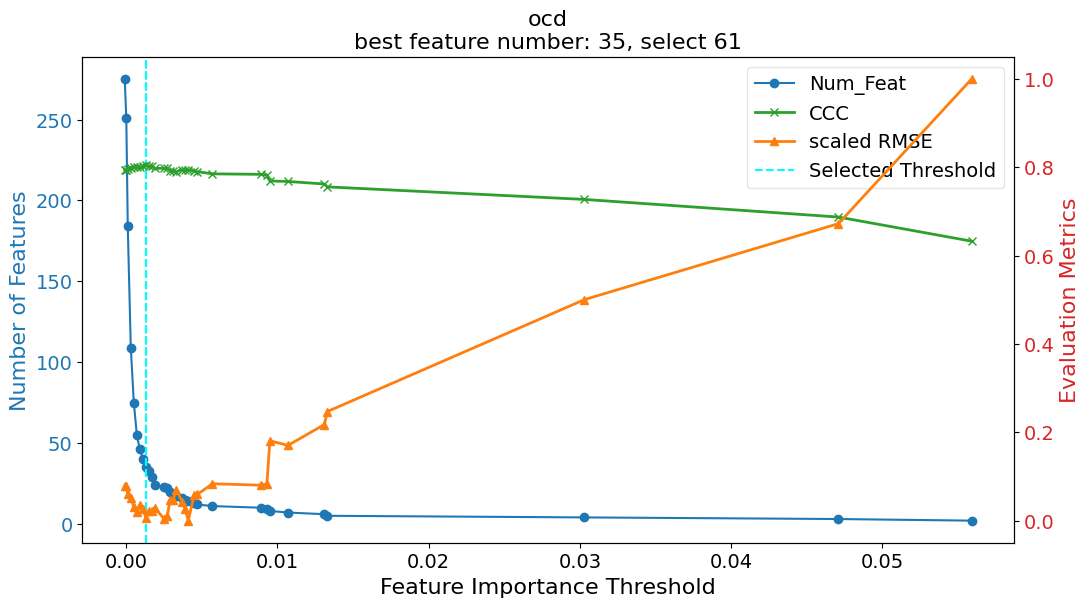

parameter fine tuning****************
[13:44:18] ----------------------rf------------------------
n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 98
max_resources_: 8005
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 135
n_resources: 98
Fitting 5 folds for each of 135 candidates, totalling 675 fits
----------
iter: 1
n_candidates: 45
n_resources: 294
Fitting 5 folds for each of 45 candidates, totalling 225 fits
----------
iter: 2
n_candidates: 15
n_resources: 882
Fitting 5 folds for each of 15 candidates, totalling 75 fits
----------
iter: 3
n_candidates: 5
n_resources: 2646
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 4
n_candidates: 2
n_resources: 7938
Fitting 5 folds for each of 2 candidates, totalling 10 fits

soc--------------------------------------------------------------
[13:44:44] processing -0.0002345829751243 ...
[13:44:54] processing -3.458297512429998e-05 ...
[13:45:03] processing 0

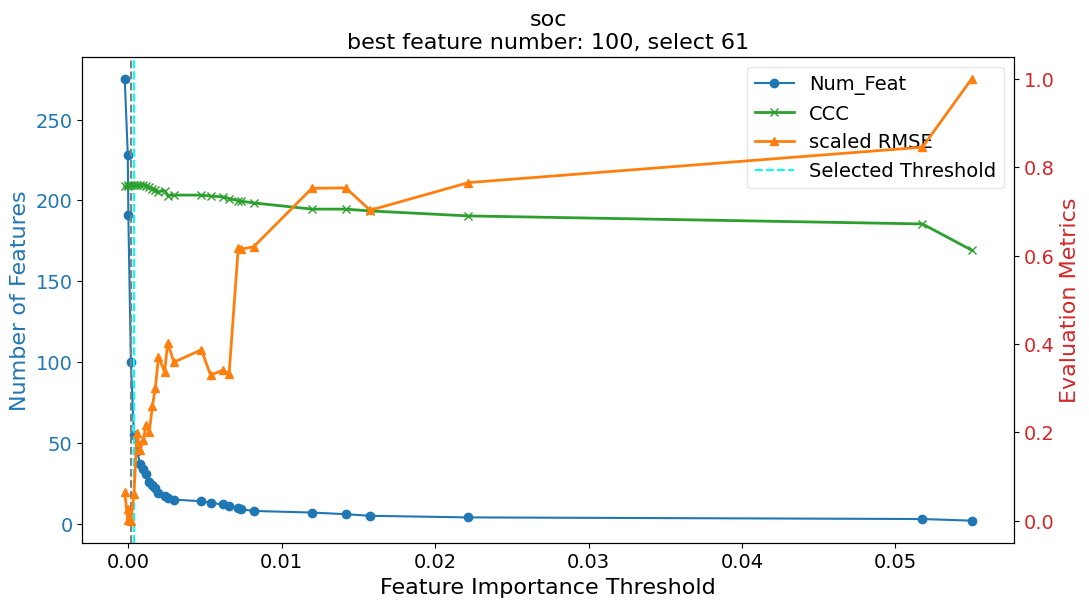

parameter fine tuning****************
[13:45:41] ----------------------rf------------------------
n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 98
max_resources_: 8005
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 135
n_resources: 98
Fitting 5 folds for each of 135 candidates, totalling 675 fits
----------
iter: 1
n_candidates: 45
n_resources: 294
Fitting 5 folds for each of 45 candidates, totalling 225 fits
----------
iter: 2
n_candidates: 15
n_resources: 882
Fitting 5 folds for each of 15 candidates, totalling 75 fits
----------
iter: 3
n_candidates: 5
n_resources: 2646
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 4
n_candidates: 2
n_resources: 7938
Fitting 5 folds for each of 2 candidates, totalling 10 fits

bulk.density--------------------------------------------------------------
[13:46:17] processing -0.0005086799875697 ...
[13:46:27] processing -0.0003086799875697 ...
[13:46:37] proces

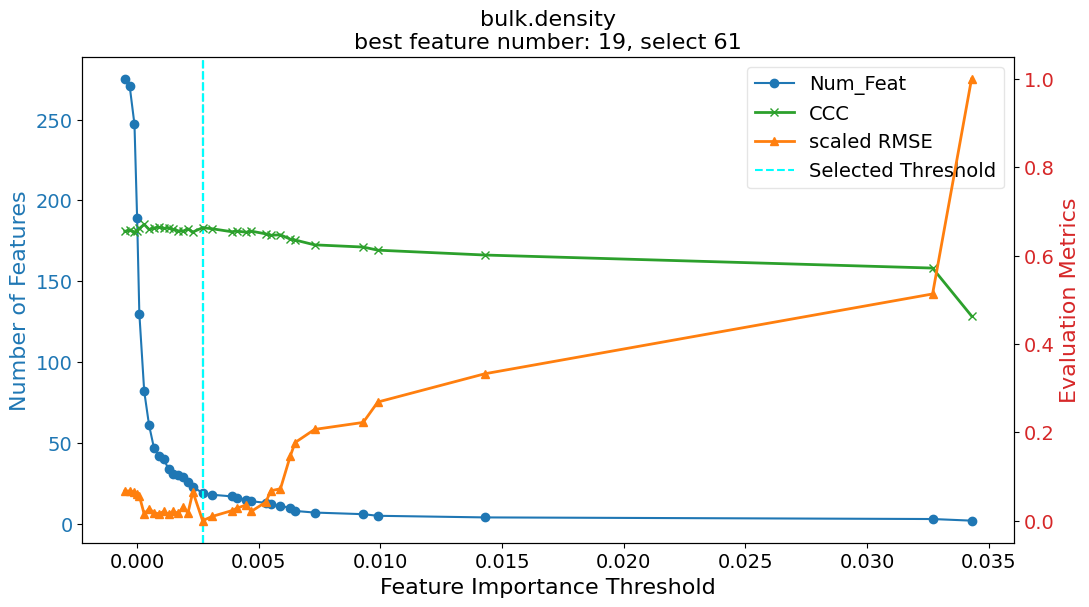

parameter fine tuning****************
[13:47:36] ----------------------rf------------------------
n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 98
max_resources_: 8006
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 135
n_resources: 98
Fitting 5 folds for each of 135 candidates, totalling 675 fits
----------
iter: 1
n_candidates: 45
n_resources: 294
Fitting 5 folds for each of 45 candidates, totalling 225 fits
----------
iter: 2
n_candidates: 15
n_resources: 882
Fitting 5 folds for each of 15 candidates, totalling 75 fits
----------
iter: 3
n_candidates: 5
n_resources: 2646
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 4
n_candidates: 2
n_resources: 7938
Fitting 5 folds for each of 2 candidates, totalling 10 fits

ph.h2o--------------------------------------------------------------
[13:48:19] processing -7.206845091684568e-05 ...
[13:48:29] processing 0.0 ...
[13:48:39] processing 0.000127931549

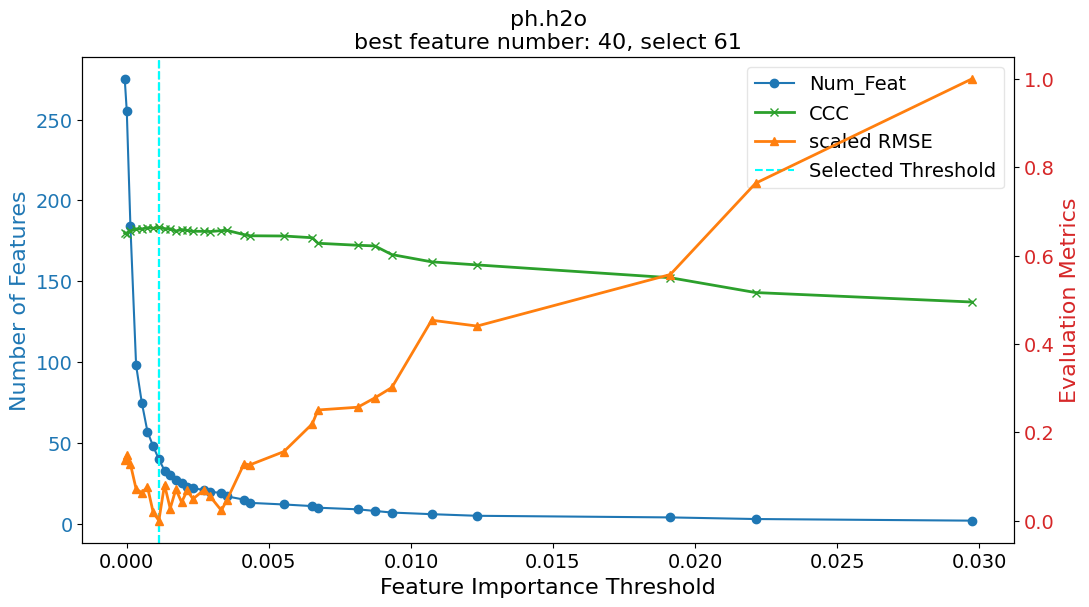

parameter fine tuning****************
[13:49:26] ----------------------rf------------------------
n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 98
max_resources_: 8007
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 135
n_resources: 98
Fitting 5 folds for each of 135 candidates, totalling 675 fits
----------
iter: 1
n_candidates: 45
n_resources: 294
Fitting 5 folds for each of 45 candidates, totalling 225 fits
----------
iter: 2
n_candidates: 15
n_resources: 882
Fitting 5 folds for each of 15 candidates, totalling 75 fits
----------
iter: 3
n_candidates: 5
n_resources: 2646
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 4
n_candidates: 2
n_resources: 7938
Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [2]:
with open(f'{folder_path}/material/soil_cov_no.bimonthly.landsat_v{version}.json', "r") as file:
    covar_cols = json.load(file)
print('total cov number: ', len(covar_cols))

for prop in prop_list:
    print(f'\n{prop}--------------------------------------------------------------')
    space = transforms_dict[prop]
    output_folder = folder_path+'/'+prop
    os.makedirs(output_folder, exist_ok=True)
    
    if space=='log1p':
        # df.loc[:,f'{prop}_log1p'] = np.log1p(df[prop])
        tgt = f'{prop}_log1p'
    # elif space=='boxcox':
    #     # df.loc[:,f'{prop}_log1p'] = np.log1p(df[prop])
    #     tgt = f'{prop}_boxcox'
    #     cal[f'{prop}_boxcox'], fitted_lambda = boxcox(cal['ocd'], lmbda=None)
    else:
        tgt = prop
        
    cal = pd.read_parquet(f'{output_folder}/data_cal_{prop}_v{version}.pq')
    cfi = pd.read_csv(f'{output_folder}/feature_cfi_{prop}_v{version}.csv') # read in
    covs = rscfi(cal, tgt, prop, space, output_folder, version, covar_cols, cfi, min_convs_num, max_convs_num, step_size=0.0002) # produce
         
    
    # ## read in existing results
    # covs = read_features(f'{output_folder}/feature_selected_{prop}_v{version}.txt') # read in
    ## parameter fine-tuning
    print('parameter fine tuning****************')
    models, model_names = parameter_fine_tuning(cal, covs, tgt, prop, output_folder, version)